In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from hw1.src.misc import transform_data

from hw2.src.RBM import RBM, get_x, sample

In [4]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [ ]:
def plot_results(nn, test_x):
    plt.figure(figsize=(16, 5))

    gs = gridspec.GridSpec(2, 5, wspace=0.0, hspace=0.0)
    ax = plt.subplot(gs[:2, :2])
    ax.plot(range(len(nn.scores)), nn.scores);

    for i in range(3):
        test_sample = test_x[np.random.randint(0, 1000)]
        ax = plt.subplot(gs[0, 2 + i]);ax.set_xticks([]);ax.set_yticks([]);
        ax.imshow((test_sample).reshape((28,28)), cmap="gray")
        ax = plt.subplot(gs[1, 2 + i]);ax.set_xticks([]);ax.set_yticks([]);
        ax.imshow(nn.feedforward(test_sample).reshape((28,28)), cmap="gray")

## 1. Data preprocessing

In [5]:
mnist = np.load("./hw1/data/mnist_28x28_train-test-cv.npz")
train_data = transform_data(mnist["train"], norm=False)
cv_data = transform_data(mnist["cv"], norm=False)
test_data = transform_data(mnist["test"], norm=False)

In [6]:
train_x, train_y = zip(*train_data)
cv_x, cv_y = zip(*cv_data)
test_x, test_y = zip(*test_data)

In [7]:
encoder_train_data = zip(train_x, train_x)
encoder_cv_data = zip(cv_x, cv_x)

#### 1.1 Noise Overlay

In [8]:
def add_noise(x):
    r = np.random.normal(0.0, 0.3, size=28*28)
    r[r < 0] = 0
    return x + r

In [80]:
noise_train_x = map(add_noise, train_x)
noise_cv_x = map(add_noise, cv_x)
noise_test_x = map(add_noise, test_x)

In [10]:
noise_encoder_train_data = zip(noise_train_x, train_x)
noise_encoder_cv_data = zip(noise_cv_x, cv_x)

## 2. Load Pre-trained weights

In [ ]:
model_784_1024 = np.load("./hw2/models/rbm_784x1024.npz")
model_1024_512 = np.load("./hw2/models/rbm_1024x512.npz")
model_512_128  = np.load("./hw2/models/rbm_512x128.npz")
model_128_32   = np.load("./hw2/models/rbm_128x32.npz")

## 3. Train Denoising Autoencoder

In [91]:
from hw1.src.NNMiniBatch import NNMiniBatch
from hw1.src.functions.activation_objs import IdentyFunc, TanhFunc, LogisticFunc, ReLuFunc
from hw1.src.functions.cost_objs import QuadraticCost, CrossEntropyCost

In [144]:
params = {
    "sizes": [784, 1024, 512, 128, 32, 128, 512, 1024, 784],
    "activation_functions": [LogisticFunc, LogisticFunc, LogisticFunc, LogisticFunc,
                             LogisticFunc, LogisticFunc, LogisticFunc, LogisticFunc],
    "cost_function": QuadraticCost,
    "epochs": 10,
    "eta": 0.01,
    "l2_rate": 0.3,
    "momentum": 0.4,
    "mini_batch_size": 2000,
    "mode": "batch",
}

nn = NNMiniBatch(**params)

w_sizes [(1024, 784), (512, 1024), (128, 512), (32, 128), (128, 32), (512, 128), (1024, 512), (784, 1024)]
b_sizes [(1, 1024), (1, 512), (1, 128), (1, 32), (1, 128), (1, 512), (1, 1024), (1, 784)]


In [145]:
# model_784_1024
nn.w[1] = model_784_1024["w"].T
nn.b[1] = model_784_1024["b"][np.newaxis, :]

# model_1024_512
nn.w[2] = model_1024_512["w"].T
nn.b[2] = model_1024_512["b"][np.newaxis, :]

# model_512_128
nn.w[3] = model_512_128["w"].T
nn.b[3] = model_512_128["b"][np.newaxis, :]

# model_128_32
nn.w[4] = model_128_32["w"].T
nn.b[4] = model_128_32["b"][np.newaxis, :]

# model_128_32
nn.w[5] = model_128_32["w"]
nn.b[5] = model_128_32["a"][np.newaxis, :]

# model_512_128
nn.w[6] = model_512_128["w"]
nn.b[6] = model_512_128["a"][np.newaxis, :]

# model_1024_512
nn.w[7] = model_1024_512["w"]
nn.b[7] = model_1024_512["a"][np.newaxis, :]

# model_784_1024
nn.w[8] = model_784_1024["w"]
nn.b[8] = model_784_1024["a"][np.newaxis, :]

In [148]:
nn.sgd(noise_encoder_train_data, noise_encoder_cv_data);

Epoch 9: 105 / 10000 | 14.0252794297 | nan

/Users/kopbob/.pyenv/versions/sphere-env-2.7.10/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/kopbob/.pyenv/versions/sphere-env-2.7.10/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


**Score = 14.0**

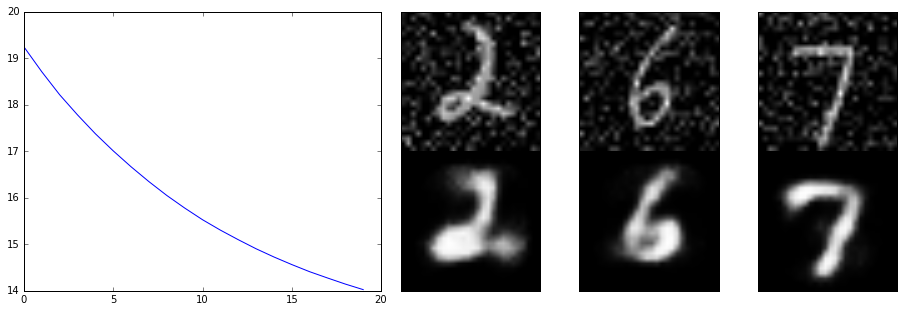

In [150]:
plot_results(nn, noise_test_x)

In [151]:
nn.feedforward(np.array(test_x));

## 4. 2D projection

In [157]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, verbose=2)
X_tsne = tsne.fit_transform(nn.z[4])

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000613
[t-SNE] Iteration 10: error = 22.7101042, gradient norm = 0.0051762
[t-SNE] Iteration 20: error = 21.9120468, gradient norm = 0.0108806
[t-SNE] Iteration 30: error = 21.5779900, gradient norm = 0.0144631
[t-SNE] Iteration 40: error = 21.4409262, gradient norm 

In [158]:
y = np.argmax(test_y, axis=1)

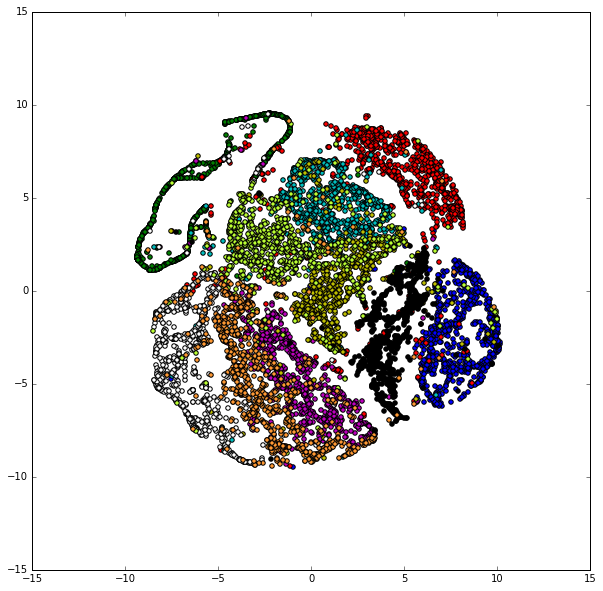

In [160]:
plt.figure(figsize=(10, 10))

for i in range(10):
    plt.scatter(X_tsne[:, 0][y == i], X_tsne[:, 1][y == i], c=colors[i])